# Basic Transformer Model - one encoder - one decoder
As saw in the last lab session

## Libraries and dataset loading (flat line outliers removed)

In [2]:
# Fix randomness and hide warnings
seed = 42
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import numpy as np
np.random.seed(seed)
import logging
import gc
import random
random.seed(seed)
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as pyplot
from sklearn.preprocessing import RobustScaler
from scipy.stats import iqr

In [21]:
def make_dataset(X, y, batch_size=128, prefetch_amt=tf.data.experimental.AUTOTUNE):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    # reshape x from (200) to (200,1) and y from (9) to (9,1)
    dataset = dataset.map(lambda x, y: (tf.reshape(x, (200,1)), tf.reshape(y, (9,1))),num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(lambda x, y: ({'encoder_inputs':x, 'decoder_inputs':y},y),num_parallel_calls=tf.data.AUTOTUNE)
    #dataset = dataset.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.cache()
    dataset = dataset.prefetch(prefetch_amt)
    return dataset

In [9]:
def build_sequences_filtered(target_data, valid_periods, window=200, stride=50, telescope=18):
    assert window % stride == 0
    outlier_detection_length = 50
    delta = 0.005
    outliers = []
    dataset = []
    labels = []
    for i, signal in enumerate(target_data):
        for j in np.arange(min(valid_periods[i][0],len(signal)-window-telescope),len(signal)-window-telescope,stride):
            input_sequence = signal[j:j+window]
            output_sequence = signal[j+window:j+window+telescope]
            grad_less_delta = np.abs(np.gradient(input_sequence)) < delta
            # Now we have an array of 0s and 1s
            temp = np.diff(np.where(np.concatenate(([grad_less_delta[0]],grad_less_delta[:-1] != grad_less_delta[1:],[True])))[0])[::2]
            # If temp contains at least one value that is greater than outlier_detection_length, then we have an outlier
            if np.any(temp > outlier_detection_length):
                outliers.append(i)
            else:
                dataset.append(input_sequence)
                labels.append(output_sequence)
    dataset = np.array(dataset)
    labels = np.array(labels)
    medians = np.median(dataset,axis=1)
    median_labels_telescope = np.median(labels,axis=1)
    print(len(outliers))
    return dataset, labels, medians, median_labels_telescope

In [10]:
telescope = 9
batch_size = 128
epochs = 200
window = 200
stride = 10
data = np.load("/kaggle/input/timeseries/training_data.npy")
categories = np.load("/kaggle/input/timeseries/categories.npy")
valid_periods = np.load("/kaggle/input/timeseries/valid_periods.npy")
X, y, median_X, median_y = build_sequences_filtered(data, valid_periods, window, stride, telescope)
norm_X, norm_y = (X-median_X[:,None]), (y-median_y[:,None])#/iqr_y[:,None]
X_train, X_val, y_train, y_val, norm_X_train, norm_X_val, norm_y_train, norm_y_val, median_y_train, median_y_val = train_test_split(X, y, norm_X, norm_y, median_y, test_size=0.2, random_state=42)
print(X.shape, y.shape)

16134
(223690, 200) (223690, 9)


## Model definition
For input embeddings, we tried the TokenAndPositionEmbedding provided in the last lab, as well as the fully trainable ProjectionAndPosition embedding layer from PatchTST model

In [12]:
class ProjectionAndPosition(tfkl.Layer):
    def __init__(self, window = 200, emb_size = 10):
        super(ProjectionAndPosition, self).__init__()
        self.emb_size = emb_size  # Output dimensions
        self.window = window

    def build(self, input_shape):
        super(ProjectionAndPosition, self).build(input_shape)
        batch_size = input_shape[0]
        self.W_p = self.add_weight(shape=(1, self.emb_size),initializer='random_normal',trainable=True,name='W_p')
        self.W_pos = self.add_weight(shape=(self.window, self.emb_size),initializer='random_normal',trainable=True,name='W_pos')

    def call(self, inputs):
        # Perform the transformation
        y = tf.matmul(inputs, self.W_p) + self.W_pos
        return y

    def get_config(self):
        config = {'emb_size': self.emb_size, 'window': self.window}
        base_config = super(ProjectionAndPosition, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen,  embed_dim, vocab_size=200, **kwargs):
        """
        Initialize the layers for token and position embeddings.

        Args:
        maxlen (int): The maximum length of the input sequences.
        vocab_size (int): The size of the vocabulary.
        embed_dim (int): The dimension of the embedding vectors.
        """
        super().__init__(**kwargs)
        self.maxlen = maxlen
        self.token_emb = tfkl.LSTM(embed_dim, return_sequences=True)#tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)#input_dim=vocab_size,
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        """
        Perform the embedding of tokens and positions and return their sum.

        Args:
        x (tf.Tensor): The input tensor containing token indices.

        Returns:
        tf.Tensor: The tensor resulting from adding token and position embeddings.
        """
        #maxlen = tf.shape(x)[-1]
        #print(x.shape)
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(tf.expand_dims(x,axis=-1))
        return x + positions
    
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        """
        Initialize the Transformer Encoder Block.

        Args:
        embed_dim (int): Dimension of the embedding layer.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimension of the feed-forward network.
        rate (float): Dropout rate.
        """
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential([tfkl.Dense(ff_dim, activation="relu"), tfkl.Dense(embed_dim)])
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)

    def call(self, inputs, training):
        """
        Process the input through the Transformer Encoder Block.

        Args:
        inputs (tf.Tensor): Input tensor for the encoder block.
        training (bool): Indicates whether the model is in training mode.

        Returns:
        tf.Tensor: The output of the encoder block.
        """
        attn_output = self.att(inputs, inputs)  # Self-attention
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Add & Normalize

        ffn_output = self.ffn(out1)  # Feed-forward network
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)  # Add & Normalize
    
class TransformerDecoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        """
        Initialize the Transformer Decoder Block.

        Args:
        embed_dim (int): Dimension of the embedding layer.
        num_heads (int): Number of attention heads.
        ff_dim (int): Dimension of the feed-forward network.
        rate (float): Dropout rate.
        """
        super().__init__(**kwargs)
        self.att1 = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential([tfkl.Dense(ff_dim, activation="relu"), tfkl.Dense(embed_dim)])
        self.layernorm1, self.layernorm2, self.layernorm3 = [tfkl.LayerNormalization(epsilon=1e-6) for _ in range(3)]
        self.dropout1, self.dropout2, self.dropout3 = [tfkl.Dropout(rate) for _ in range(3)]

    def call(self, inputs, encoder_outputs, training, mask=None):
        """
        Process the input through the Transformer Decoder Block.

        Args:
    
        inputs (tf.Tensor): Input tensor for the decoder block.
        encoder_outputs (tf.Tensor): Output tensor from the encoder.
        training (bool): Indicates whether the model is in training mode.
        mask (tf.Tensor, optional): Optional mask for the inputs.

        Returns:
        tf.Tensor: The output of the decoder block.
        """
        causal_mask = self.get_causal_attention_mask(inputs)
        padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32") if mask is not None else None
        padding_mask = tf.minimum(padding_mask, causal_mask) if mask is not None else None

        attn_output_1 = self.att1(inputs, inputs, inputs, attention_mask=causal_mask)
        attn_output_1 = self.dropout1(attn_output_1, training=training)
        out_1 = self.layernorm1(inputs + attn_output_1)

        attn_output_2 = self.att2(out_1, encoder_outputs, encoder_outputs, attention_mask=padding_mask)
        attn_output_2 = self.dropout2(attn_output_2, training=training)
        out_2 = self.layernorm2(out_1 + attn_output_2)

        ffn_output = self.ffn(out_2)
        ffn_output = self.dropout3(ffn_output, training=training)

        return self.layernorm3(out_2 + ffn_output)

    def get_causal_attention_mask(self, inputs):
        """
        Creates a causal attention mask to prevent the model from attending to future timesteps.

        Args:
        inputs (tf.Tensor): The input tensor.

        Returns:
        tf.Tensor: The causal attention mask.
        """
        batch_size, sequence_length = tf.shape(inputs)[0], tf.shape(inputs)[1]
        i, j = tf.range(sequence_length)[:, tf.newaxis], tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        return tf.tile(tf.reshape(mask, (1, sequence_length, sequence_length)), [batch_size, 1, 1])

In [27]:
# Define Transformer hyperparameters
embed_dim = 200
latent_dim = 200
num_heads = 4

Model: "Encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer  [(None, 200, 1)]          0         
 )                                                               
                                                                 
 projection_and_position_6   (None, 200, 200)          40200     
 (ProjectionAndPosition)                                         
                                                                 
 transformer_encoder_block_  (None, 200, 200)          723800    
 2 (TransformerEncoderBlock                                      
 )                                                               
                                                                 
Total params: 764000 (2.91 MB)
Trainable params: 764000 (2.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


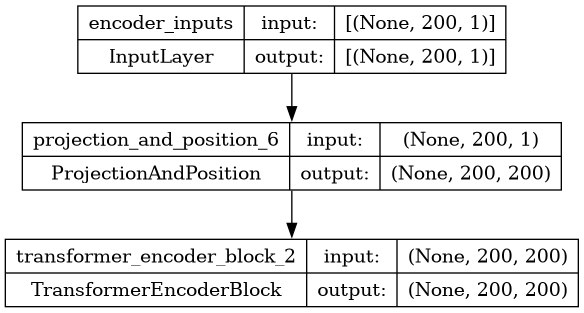

In [28]:
def create_encoder(sequence_length, embed_dim, num_heads, latent_dim):
    """
    Creates an encoder model using token and position embeddings, and a transformer encoder block.
    sequence_length (int): The maximum sequence length of the input.
    vocab_size (int): The size of the vocabulary.
    embed_dim (int): The dimension of the embedding vectors.
    num_heads (int): The number of attention heads in the transformer.
    latent_dim (int): The dimension of the latent space in the feed-forward network of the transformer.
    Returns:
    tfk.Model: The encoder model.
    """
    encoder_inputs = tfk.Input(shape=(window,1), name="encoder_inputs")
    x = ProjectionAndPosition(window, embed_dim)(encoder_inputs)
    encoder_outputs = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
    encoder = tfk.Model(encoder_inputs, encoder_outputs, name="Encoder")
    return encoder

encoder = create_encoder(window, embed_dim, num_heads, latent_dim)
# Display summary and plot the model
encoder.summary(expand_nested=True)
tfk.utils.plot_model(encoder, show_shapes=True, expand_nested=True, to_file='encoder_model.png')

Model: "Decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 decoder_inputs (InputLayer  [(None, 9, 1)]               0         []                            
 )                                                                                                
                                                                                                  
 projection_and_position_7   (None, 9, 200)               2000      ['decoder_inputs[0][0]']      
 (ProjectionAndPosition)                                                                          
                                                                                                  
 decoder_state_inputs (Inpu  [(None, 200, 200)]           0         []                            
 tLayer)                                                                                    

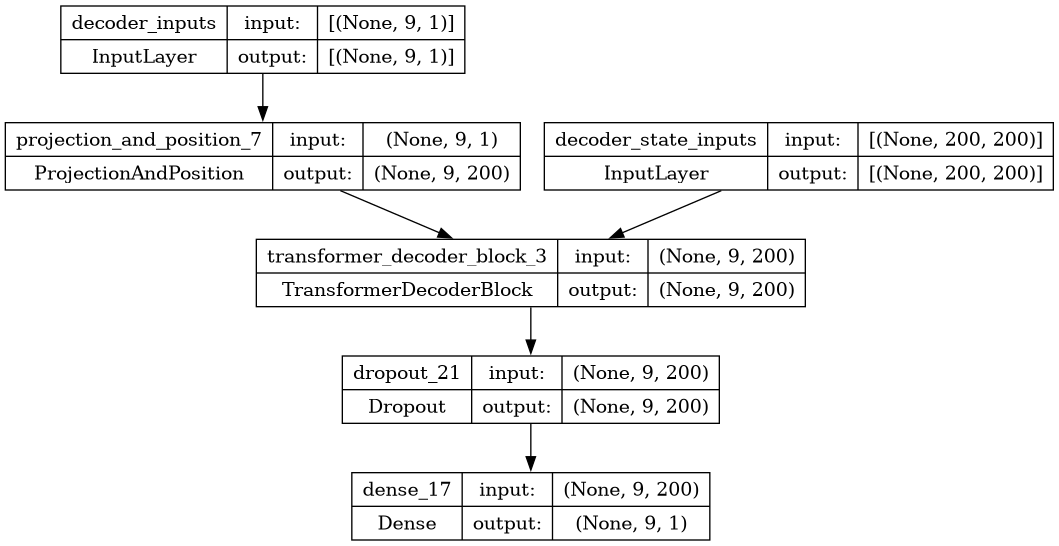

In [29]:
def create_decoder(telescope, embed_dim, num_heads, latent_dim):
    """
    Creates a decoder model using token and position embeddings, a transformer decoder block,
    followed by dropout and a dense softmax layer.
    sequence_length (int): Maximum sequence length of the input.
    vocab_size (int): Size of the vocabulary.
    embed_dim (int): Dimension of the embedding vectors.
    num_heads (int): Number of attention heads in the transformer.
    latent_dim (int): Dimension of the latent space in the feed-forward network of the transformer.

    Returns:
    tfk.Model: The decoder model.
    """
    decoder_inputs = tfk.Input(shape=(telescope,1), name="decoder_inputs")
    encoded_seq_inputs = tfk.Input(shape=(window, embed_dim), name="decoder_state_inputs")
    x = ProjectionAndPosition(telescope, embed_dim)(decoder_inputs)
    x = TransformerDecoderBlock(embed_dim, num_heads, latent_dim)(x, encoded_seq_inputs)
    x = tfkl.Dropout(0.5)(x)
    decoder_outputs = tfkl.Dense(1, activation="softmax")(x)
    decoder = tfk.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs, name="Decoder")
    return decoder

decoder = create_decoder(telescope, embed_dim, num_heads, latent_dim)

# Display summary and plot the model
decoder.summary(expand_nested=True)
tfk.utils.plot_model(decoder, show_shapes=True, expand_nested=True, to_file='decoder_model.png')

Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 200, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 decoder_inputs (InputLayer  [(None, 9, 1)]               0         []                            
 )                                                                                                
                                                                                                  
 Encoder (Functional)        (None, 200, 200)             764000    ['encoder_inputs[0][0]']      
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

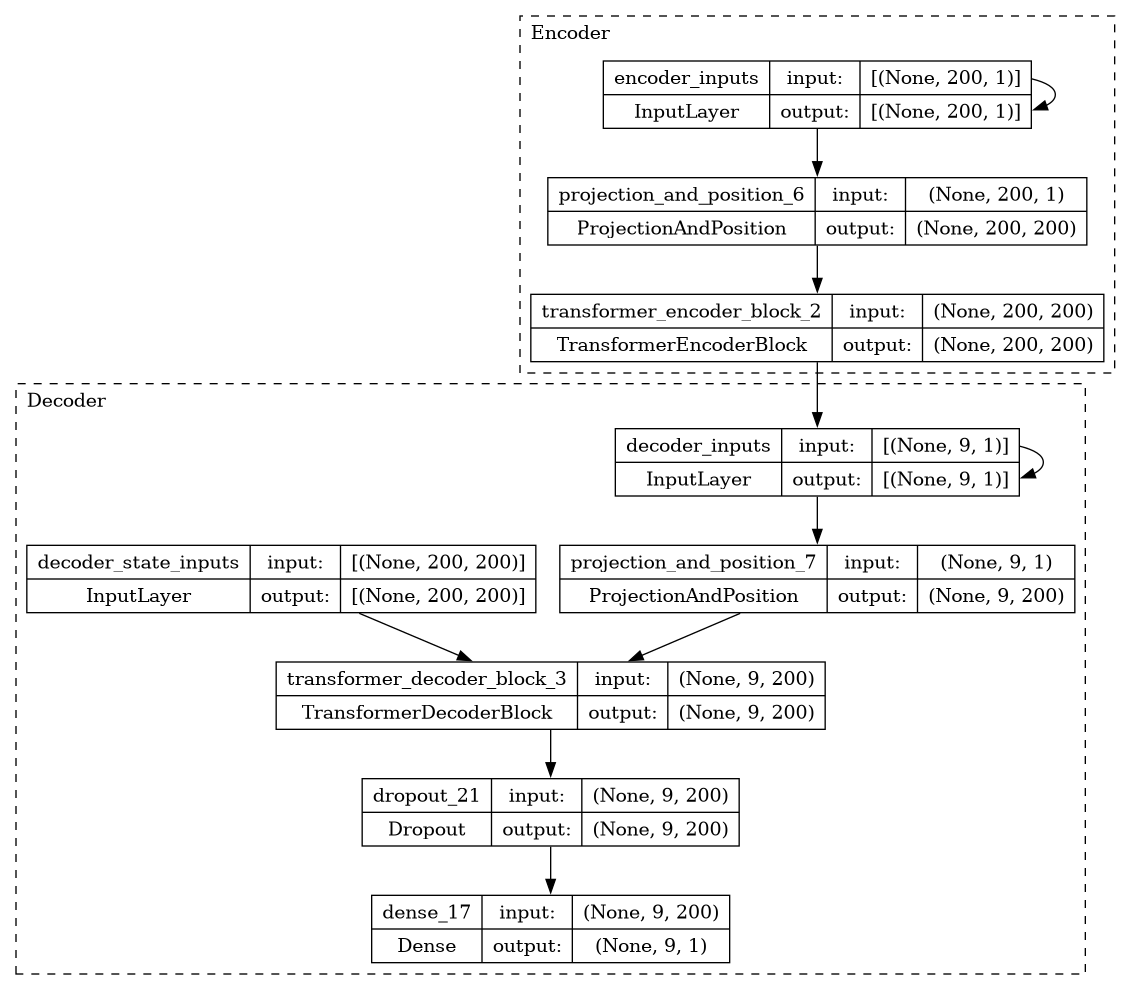

In [30]:
def create_transformer(encoder, decoder):
    """
    Creates a Transformer model by connecting the encoder and decoder models.

    Args:
    encoder (tfk.Model): The encoder model.
    decoder (tfk.Model): The decoder model.

    Returns:
    tfk.Model: The complete Transformer model.
    """
    encoder_inputs = encoder.input
    decoder_inputs = decoder.input[0]  # First input of the decoder (decoder_inputs)
    encoder_outputs = encoder(encoder_inputs)
    #encoder_outputs = tf.squeeze(encoder_outputs,axis=-1)
    decoder_outputs = decoder([decoder_inputs, encoder_outputs])
    transformer = tfk.Model([encoder_inputs,decoder_inputs], decoder_outputs, name="Transformer")
    return transformer

# Assuming 'encoder' and 'decoder' are already defined
transformer = create_transformer(encoder, decoder)

# Display the model summary and visualize the model
transformer.summary(expand_nested=True)
tfk.utils.plot_model(transformer, show_shapes=True, expand_nested=True, to_file='transformer_model.png')

## Model Training

In [31]:
learning_rate = 1e-3
optimizer = tfk.optimizers.Adam(learning_rate)
loss = tfk.losses.MeanSquaredError()
metrics = ["mae"]

transformer.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = transformer.fit(
    make_dataset(norm_X_train,norm_y_train,batch_size),
    validation_data=make_dataset(norm_X_val,norm_y_val,batch_size),
    #batch_size = 64,
    epochs = epochs,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=20, min_delta=5e-6, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=4, factor=0.1)
    ]
).history